In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
yelps = pd.read_csv('sentiment/yelps.csv')

# Shuffle data frame for later
yelps = yelps.sample(frac=1)

#### Notes 

Tokenizer:
- Splits string into "tokens", usually defined by whitespaces, punctuation, etc.
- Possible to also throw away punctuation in the same step

In [3]:
from bs4 import BeautifulSoup

def clean_yelp(s):
    s = BeautifulSoup(s, 'html5lib').get_text()
    s = ' '.join(s.split())
    s = s.strip().lower()
    return s

def tokenize(s):
    """ Returns a list of strings (tokens) from the document """

    # Implement this function!
    # Hint: If you look at the sklearn source code on github, 
    # you will find a good regular expression they use as a default
    # tokenizer in CountVectorizer -- this is the tokenizer
    # we have been using until now!
    # But you need to implement your own now. 
    
    # Token pattern, stolen from sklearn
    re_pattern = r"(?u)\b\w\w+\b"

    token_pattern = re.compile(re_pattern)
   
    return  token_pattern.findall(s)

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

# Create a count vectorizer, using the preprocessor and tokenizer from above
# use TruncatedSVD from Sklearn to generate a term embedding matrix for your data
# that is 100 dimensional in size.
# Embed your documents via that term embedding matrix (this is just the PCA of the 
# TF matrix, as returned by "transform" on TruncatedSVD

# Here you should have TWO vector representations of your Yelp data: 
# 1. The original TF matrix
# 2. The first 100 components of the PCA of that matrix, as performed by TruncatedSVD

In [78]:
# Count Vectorizer using the preprocessor and the tokenizer
countVectorizer = CountVectorizer(preprocessor=clean_yelp,tokenizer= tokenize)
X = countVectorizer.fit_transform(yelps.text)

# Embed document 
embed = TruncatedSVD(n_components=100)
embedding = embed.fit_transform(X)

/home/adam/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:272: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/home/adam/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:335: UserWarning: "https://www.consumeraffairs.com/news/mypillow-gets-a-rude-awakening-as-the-better-business-bureau-gives-it-an-f-010517.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/home/adam/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:272: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [5]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

def test_holdout_vectors(V, y, cutoff):
    model = LogisticRegression(solver="lbfgs", max_iter=300)
    model.fit(V[:cutoff], y[:cutoff])
    preds = model.predict(V[cutoff:])
    return accuracy_score(preds, y[cutoff:])

In [80]:
# Test your vector representations using the above function, test_holdout_vectors. 
# for several levels of "cutoff". 

# This function simulates training on a small part of your data and testing on the rest.
# Thus, it's as though you have some labelled data but a bunch of unlabelled data. 
# This is essentially a semi-supervised situation. 

# Do the word embeddings generated via SVD allow you to pull information from the 
# unlabeled data and improve your score given a small training set? 

cutoff = np.arange(500,10500,step = 500)
y = yelps.positive

score_vectorized = [test_holdout_vectors(X,y,training_size) for training_size in cutoff ]
score_embedding = [test_holdout_vectors(embedding,y,training_size) for training_size in cutoff ]



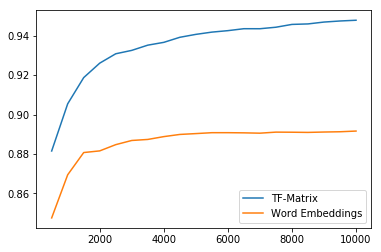

In [81]:
sns.lineplot(cutoff,score_vectorized,label = "TF-Matrix")
sns.lineplot(cutoff,score_embedding,label ="Word Embeddings")

Looks like the embeddings didn't help?

/home/adam/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:272: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/home/adam/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:335: UserWarning: "https://www.consumeraffairs.com/news/mypillow-gets-a-rude-awakening-as-the-better-business-bureau-gives-it-an-f-010517.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/home/adam/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:272: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [6]:
from gensim.models import Word2Vec

# Next, create another term embedding via Word2Vec, also 100 dimensional
# Look at the documentation from the library gensim and see what hyperparameters
# you can choose to tune. 
# Note: training takes time, so you probably won't want to try too many!

# pass the cleaned and tokenized yelp reviews as "sentences" to your model
# to build the vocabulary and train the word vectors. 

sentences = yelps.text.apply(clean_yelp).apply(tokenize)



In [115]:
model = Word2Vec(sentences=sentences, size =1000,window=5, min_count=1, workers=4)

In [ ]:
# use the embed_w2v function to embed your Yelp reviews using the new
# word2vec word embeddings. Each review will be a normalized sum of the
# words that it is made of. 
# See how this improves the scores in the classification task using
# test_holdout_vectors -- is word2vec better? At what training-set sizes does it help
# more? 

In [42]:
import numpy as np

def embed_w2v(tokens, w2v):
    idxs = [w2v.wv.vocab.get(t) for t in tokens]
    idxs = [t.index for t in idxs if t]
    N = w2v.wv.vectors.shape[1]
    if len(idxs) < 1:
        return np.zeros(N)
    a = np.sum(w2v.wv.vectors[idxs, :], axis=0)
    a /= np.linalg.norm(a)
    return a



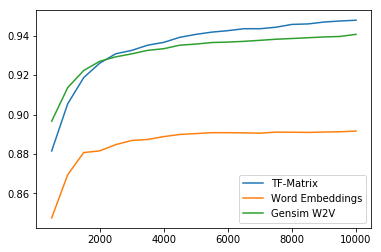

In [116]:
# Embedding
w2v_embedding = np.array([embed_w2v(t, model) for t in sentences])

# Testing
w2v_score = [test_holdout_vectors(w2v_embedding,y,training_size) for training_size in cutoff ]

sns.lineplot(cutoff,score_vectorized,label = "TF-Matrix")
sns.lineplot(cutoff,score_embedding,label ="Word Embeddings")
sns.lineplot(cutoff,w2v_score,label = "Gensim W2V")

In [7]:
import pandas as pd
import re
from functools import reduce
import emoji



pats = [re.compile(r'https?:\/\/[^\s]+'), 
        re.compile(r'rt\s*@\w+\s?:?'),
        re.compile(r'@\w+')]

def clean_twitter(s):
    """ Cleans Twitter specific issues
    
    Should probably clean out mentions, URLs, and RT's.
    """
    s = s.lower()
    _sub = lambda s,pat: re.sub(pat, '', s)
    s = reduce(_sub, pats, s)
    s = ' '.join(s.split()).strip()
    # TODO: Use regular expressions to remove unwanted
    # text and clean up our tweets to be more usable!

    s = re.sub("@"," ",s) # @
    s = re.sub("RT","",s) # Retweets
    s = re.sub("&amp;", "and",s) # & 
    s = re.sub(r"http\S+", "", s) # Hyperlinks
    s = re.sub("\n","",s) # line break
    s = re.sub("%", " percent", s) #percentages
    s = ' '.join(s.split()) # Extra Whitespace
    s = emoji.demojize(s) # Convergt Emoji to text

    # BONUS: Try using the library "spacy" to 
    # do further processing, such as lemmatizing
    # or replacing Named Entities with constants (i.e. "[NAMED]")
    # or adding the part of speech or dependency code to the word 

    return s

In [8]:
# Load tweet!
# NOTE: this file needs to be downloaded from Box! 

with open('tweets/tweets.txt') as f:
    tweets = pd.Series(f.readlines())

In [ ]:
# Now embed this twitter data, again using Word2Vec and LSA (SVD)
# you don't have any labels, but you might be able to 
# find some interesting phenomena. 

# Explore using either or both of the following tools: 
# 1. Word2Vec has a built in feature for getting most similar
# words, including via positive/negative examples (subtraction)
# What happens when you subtract "hillary" from "trump"? 
# 
# Bonus: build a similar feature for your LSA features and
# see if you can do similar vector math

# 2. Use the visualize_dist function to see how
# the tweet-tweet distance looks for a selection
# of random tweets. Do you agree with the distance? 
# Does one embedding seem better than another? 

In [9]:
# Cleaning 
X_twitter = [tokenize(clean_twitter(tweet)) for tweet in tweets]

In [10]:
# Train word2vec model
tweetModel = Word2Vec(sentences=X_twitter, size =100,window=5, min_count=1, workers=3)

In [32]:
# Some words of interest
words = ["hillary", "trump", "democrat", "republican", "obama", "president","fake","true",
         "money","poor","rich","lying","honest", "crooked"]

simialrity_df = pd.DataFrame(columns = words, index = words)

for w1 in words:
    for w2 in words:
        simialrity_df.loc[w1, w2] = tweetModel.wv.similarity(w1,w2)

In [35]:
tweetModel.wv.most_similar(positive= ["hillary"] ,negative= ["trump"])

[('hilary', 0.5129923820495605),
 ('climateconversations', 0.505402684211731),
 ('hilliary', 0.5016294121742249),
 ('killary', 0.49582090973854065),
 ('shawnlucas', 0.4844779372215271),
 ('clintonitis', 0.47961723804473877),
 ('toodumbtojail', 0.4683007001876831),
 ('chelsea', 0.4672538638114929),
 ('fdn', 0.4622959494590759),
 ('pinealgland', 0.45461732149124146)]

In [36]:
tweetModel.wv.most_similar(negative= ["hillary"] ,positive= ["trump"])

[('trumps', 0.451570600271225),
 ('5wordnewyorkvalues', 0.4271358847618103),
 ('koreanupdates', 0.42165547609329224),
 ('eiffel', 0.41953790187835693),
 ('happybirthdaybarron', 0.41757717728614807),
 ('bloomington', 0.4162389636039734),
 ('ster', 0.4161994457244873),
 ('halmets', 0.41337713599205017),
 ('koreanw', 0.41019582748413086),
 ('koreandrama', 0.40624570846557617)]

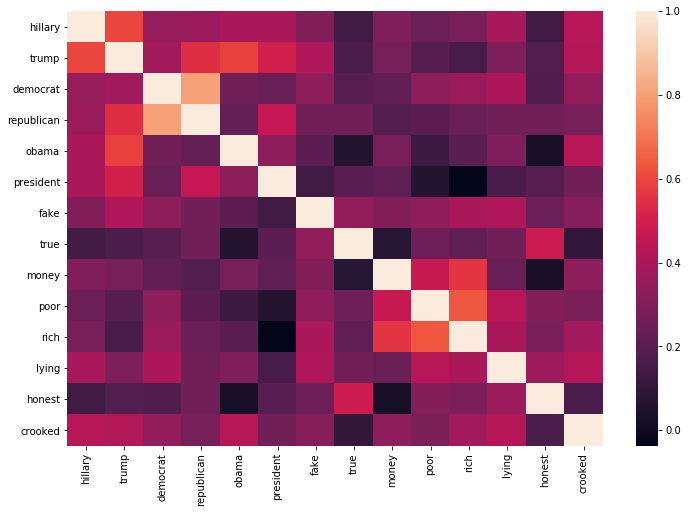

In [33]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 12,8

sns.heatmap(simialrity_df.astype(float));

Some observations:
- Hillary and Trump are quite similar
- Democrat and Republican also similar,maybe because both are parties?
- Obama complete opposite of true and honest (republican twitter? )
- Trimp closer to honest than hillary

In [48]:
countvectorizer = CountVectorizer(preprocessor=clean_twitter)
tf_twitter = countvectorizer.fit_transform(tweets)

truncatedSVD = TruncatedSVD(n_components=100)
svd_twitter = truncatedSVD.fit_transform(tf_twitter)

NameError: name 'TF_tweets' is not defined

In [39]:
from scipy.spatial.distance import pdist,squareform
import seaborn as sns

def visualize_dist(V, tweets, idxs):
    """ Visualize distances in heatmap

    V is the vector of embeddings 
    tweets is a list or series that converts from idx to tweet
    idxs is a list of integers that you would like to compare (<= 5 probably)
    """
    m = squareform(pdist(V[idxs], 'cosine'))
    _ = sns.heatmap(pd.DataFrame(m, columns = tweets[idxs], index= tweets[idxs]))

In [44]:
twitter_embedding = np.array([embed_w2v(t, tweetModel) for t in X_twitter ])

In [ ]:
# 2. Use the visualize_dist function to see how
# the tweet-tweet distance looks for a selection
# of random tweets. Do you agree with the distance? 
# Does one embedding seem better than another? 

In [58]:
idx = np.random.randint(0, high=len(tweets), size=5)
[clean_twitter(tweets[i]) for i in idx]

['bo might pass an executive order putting this on the rio grande. enlist: we need patriots.',
 'border security is national security #buildthewall',
 '#flag #southerncharm #southcarolina #wakeupamerica #wakeupamericans',
 "video: levantine front copy #isis execution video but promote imprisonment and 'teaching'",
 'german bikers are defending their women by beating the hell out of “muslim refugees” #tcot']

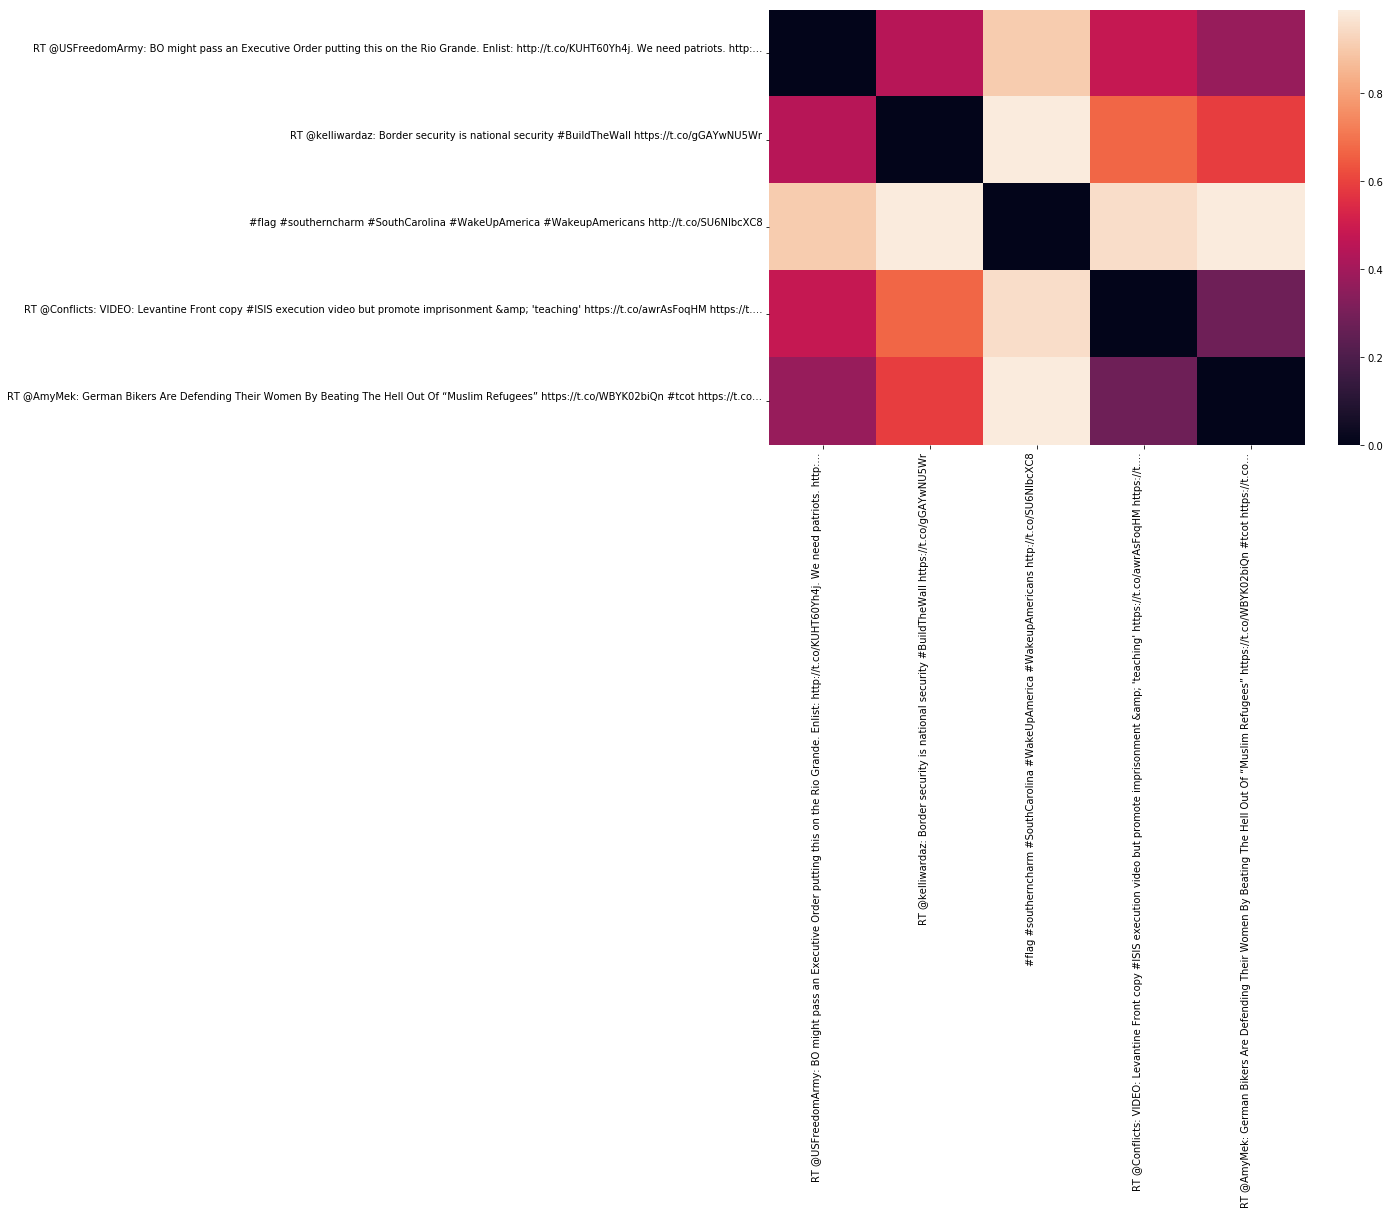

In [59]:
visualize_dist(twitter_embedding, tweets, idx)

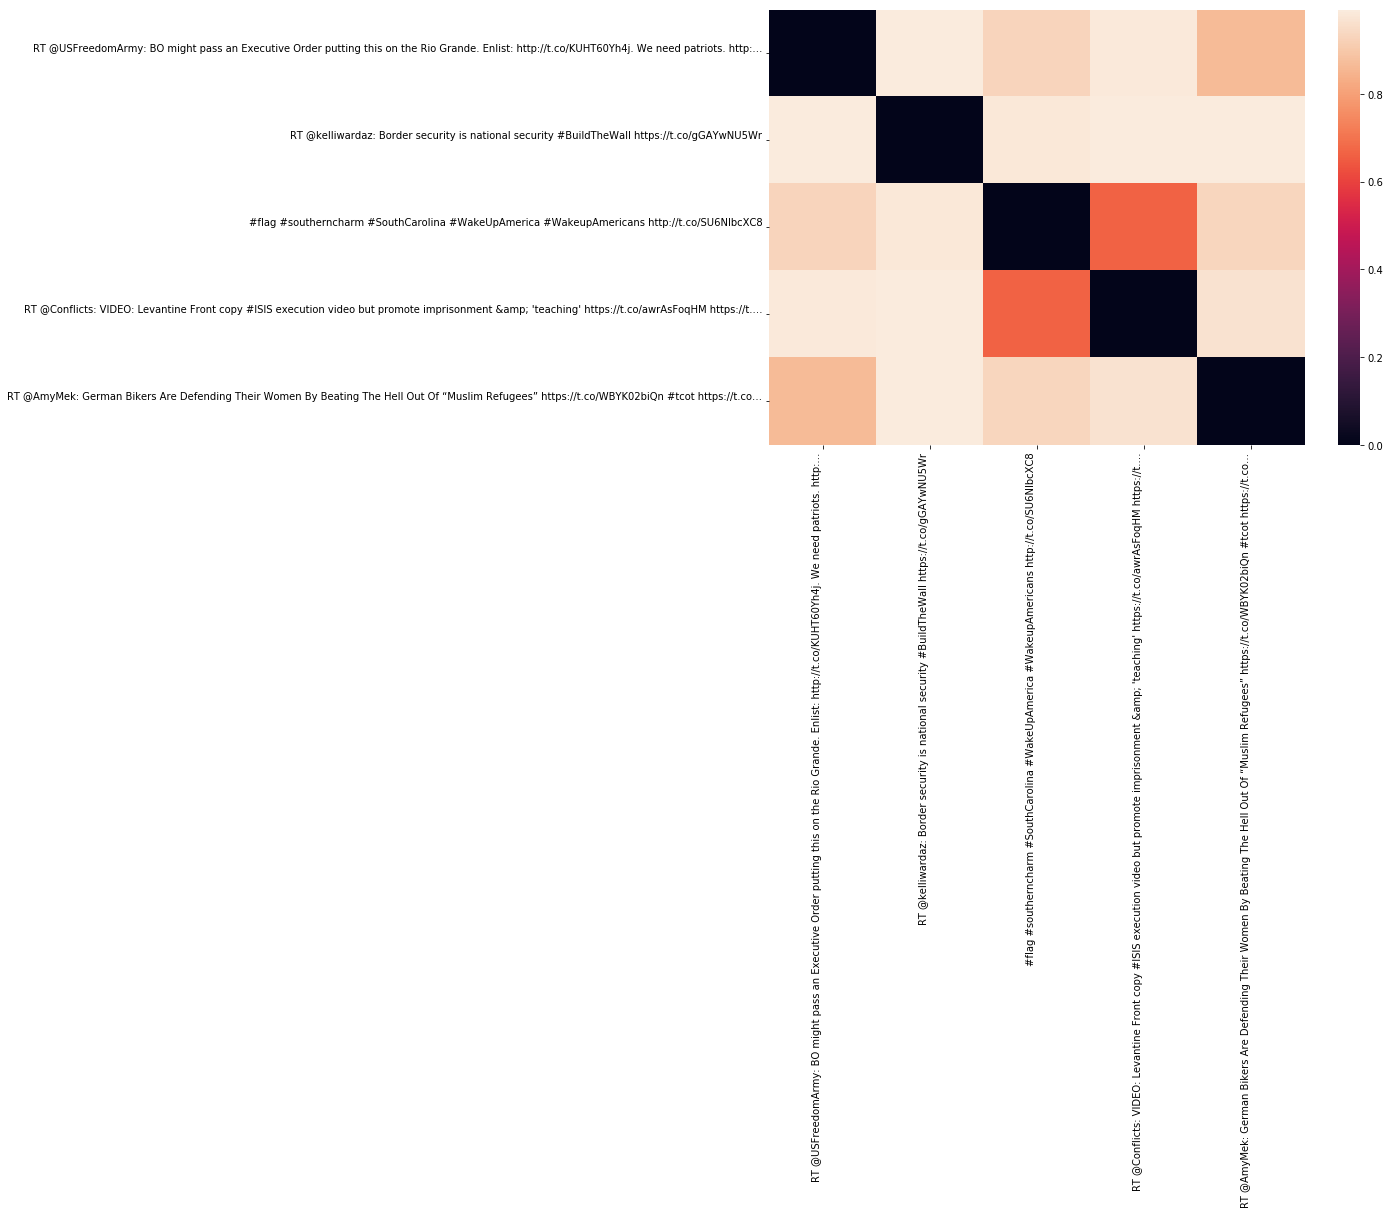

In [60]:
visualize_dist(svd_twitter, tweets, idx)

- The SVD picks up the similarities a lot better than the word2vec
- Most of these tweets seem similar when reading them, so I'd agree with the SVD representation.
- Similarity in the sense that they sound almost right-extremist with topics on Islam, border protection and security.

In [ ]:
# More bonus!
# Use one of the following pre-embedded models and see if your yelp scores improve? 
# What about your Twitter explorations?

# https://github.com/RaRe-Technologies/gensim-data